In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

In [3]:
from graphviz import Digraph

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [4]:
class Value:
    
    def __init__(self, data, _children=(), _op=(), label=None):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data}, label={self.label})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supports int/float for now"
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        
        out._backward = _backward
        return out
    
    def __radd__(self, other): # other + self
        return self + other

    def __rmul__(self, other): # other * self
        return self * other
    
    def __truediv__(self, other): # self / other
        return self * other**-1
    
    def __neg__(self): # -self
        return self * -1
    
    def __sub__(self, other): # self - other
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        
        out._backward = _backward
        return out 
    
    def backward(self):
        def topo_sort(node):
            topo = []
            visited = set()
            def build_topo(v):
                if v not in visited:
                    visited.add(v)
                    for child in v._prev:
                        build_topo(child)
                    topo.append(v)
            build_topo(node)
            return topo
        
        self.grad = 1.0
        for node in reversed(topo_sort(self)):
            node._backward()

In [5]:
class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi,xi in zip(self.w, x, strict=True)), self.b)
        out = act.tanh()
        return out

class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

class MLP:
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

x = [2.0, 3.0, 4.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=0.3080381474532082, label=None)

In [6]:
# lets create a dataset, run it through the mlp, get the predictions, compare to targets

In [7]:
# 3 dim dataset
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # targets

# predictions is just the forward
ypreds = [n(x) for x in xs]
ypreds

[Value(data=0.4188593517141868, label=None),
 Value(data=0.2600839075714343, label=None),
 Value(data=0.29063992931925875, label=None),
 Value(data=0.1541594207118325, label=None)]

In [8]:
# time for calculating loss (a number that measures how good the NN is doing compared to the targets)
# lower the loss the better the NN is doing
# so we need to minimize the loss

In [9]:
# we are using mean squared loss(MSE) Mean of squares of differences

In [10]:
def mse(targets, preds):
    return sum((p - t)**2 for t,p in zip(targets, preds))

loss = mse(ys, ypreds)

In [11]:
loss

Value(data=4.306733619934314, label=None)

In [12]:
# OMG ! Time to backward

In [13]:
loss.backward()

In [14]:
n.layers[0].neurons[0].w[0]

Value(data=-0.5708333557891283, label=None)

In [15]:
n.layers[0].neurons[0].w[0].grad

-0.09450488346289992

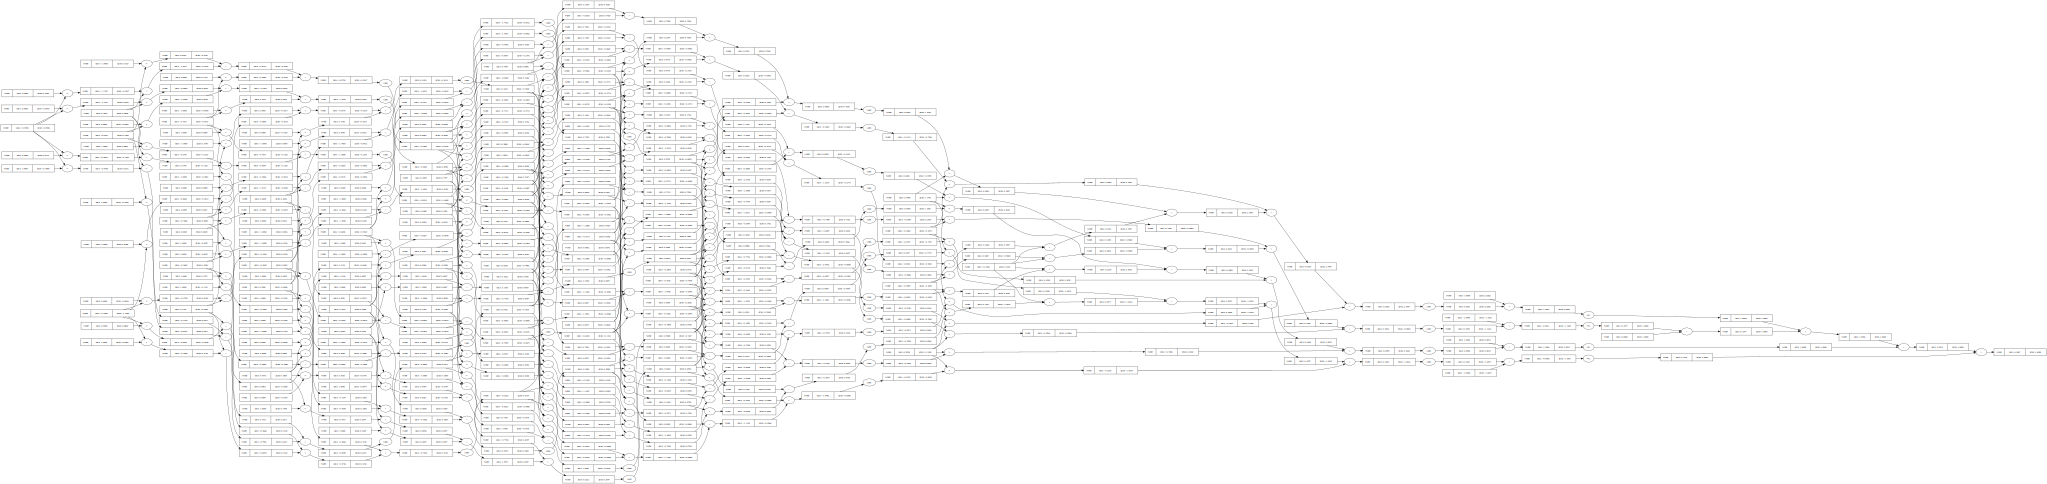

In [16]:
draw_dot(loss)

In [17]:
# next nb will try to nudge all the weights of the network to minimize the loss